<a href="https://colab.research.google.com/github/ereny123/Multitasking-MThesis-2024/blob/main/Pytorch_NET_Multitask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

In [ ]:
#create a model class
class Model(nn.Module):

  def __init__(self, in_tasks=9, in_stim=9, hidden=100, output=9, bias_weight=-2, coeff=0.3, thresh=0.0001):
    super().__init__()

    #Set Parameters
    self.bias_weight = bias_weight   # default bias weight
    self.coeff = coeff
    self.thresh = thresh

    self.task_hidden=nn.Linear(in_tasks, hidden)    #input layer(tasks) --> hidden layer
    self.stim_hidden=nn.Linear(in_stim, hidden)     #input layer(stimuls) --> hidden layer
    self.task_out=nn.Linear(in_tasks, output)       #Input Layer(tasks) --> output layer
    self.hidden_out=nn.Linear(hidden, output)       #hidden layer --> output layer

    self.task_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_tasks).uniform_(-0.1, 0.1))   #input(tasks)-->hidden  weight
    self.task_out.weight=nn.Parameter(torch.FloatTensor(output, in_tasks).uniform_(-0.1, 0.1))      #input(tasks) --> output weight
    self.stim_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_stim).uniform_(-0.1, 0.1))    #input(stimulus) -->hidden weight
    self.hidden_out.weight=nn.Parameter(torch.FloatTensor(output, hidden).uniform_(-0.1, 0.1))      #hidden-->output  weight


    self.task_hidden.bias=nn.Parameter(torch.ones(hidden) * bias_weight)                   #hidden layer bias
    self.hidden_out.bias=nn.Parameter(torch.ones(output) * bias_weight)                    #output layer bias

  def forward(self, taskData, stimulusData):

    h_act=torch.sigmoid(self.task_hidden(taskData)+self.stim_hidden(stimulusData))   #hidden layer activation
    out_act= torch.sigmoid(self.hidden_out(h_act)+self.task_out(taskData))           #output layer activation

    return h_act, out_act



In [ ]:
def plot_losses(losses, title):
   # plt.figure(figsize=(10, 6))  # Increase the figure size for better readability
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title(title)

   # plt.xticks(ticks=range(0, len(losses), max(1, len(losses) // 10)))
    plt.yticks(ticks=numpy.linspace(min(losses), max(losses), 10))
    plt.grid(True)
    plt.show()


In [ ]:
# Generate training data
def generate_dataset_multitask(split_ratio=None):

  #Generate stimulusData Patterns
  stimulusData = torch.tensor([ [0, 0, 1, 0, 0, 1, 0, 0, 1],
                                [0, 0, 1, 0, 0, 1, 0, 1, 0],
                                [0, 0, 1, 0, 0, 1, 1, 0, 0],
                                [0, 0, 1, 0, 1, 0, 0, 0, 1],
                                [0, 0, 1, 0, 1, 0, 0, 1, 0],
                                [0, 0, 1, 0, 1, 0, 1, 0, 0],
                                [0, 0, 1, 1, 0, 0, 0, 0, 1],
                                [0, 0, 1, 1, 0, 0, 0, 1, 0],
                                [0, 0, 1, 1, 0, 0, 1, 0, 0],
                                [0, 1, 0, 0, 0, 1, 0, 0, 1],
                                [0, 1, 0, 0, 1, 0, 0, 0, 1],
                                [0, 1, 0, 0, 0, 1, 0, 1, 0],
                                [0, 1, 0, 0, 0, 1, 1, 0, 0],
                                [0, 1, 0, 0, 1, 0, 0, 1, 0],
                                [0, 1, 0, 0, 1, 0, 1, 0, 0],
                                [0, 1, 0, 1, 0, 0, 0, 0, 1],
                                [0, 1, 0, 1, 0, 0, 0, 1, 0],
                                [0, 1, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 0, 1, 0, 0, 1],
                                [1, 0, 0, 0, 0, 1, 0, 1, 0],
                                [1, 0, 0, 0, 0, 1, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 1, 0],
                                [1, 0, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 1, 0],
                                [1, 0, 0, 0, 1, 0, 1, 0, 0]
                                                           ] *20 , dtype=torch.float)


# Generate task data patterns
  taskDatapattern = torch.tensor([

    [1, 1, 1, 0, 0, 0, 0, 0, 0] , #Task 1
    [1, 1, 0, 1, 0, 0, 0, 0, 0] , #Task 2
    [1, 1, 0, 0, 1, 0, 0, 0, 0] , #Task 3
    [1, 1, 0, 0, 0, 1, 0, 0, 0] , #Task 4
    [1, 1, 0, 0, 0, 0, 1, 0, 0] , #Task 5
    [1, 1, 0, 0, 0, 0, 0, 1, 0] , #Task 6
    [1, 1, 0, 0, 0, 0, 0, 0, 1] , #Task 7
    [1, 0, 1, 0, 0, 0, 0, 0, 1] , #Task 8
    [1, 0, 0, 1, 0, 0, 0, 0, 1] , #Task 9
    [1, 0, 0, 0, 1, 0, 0, 0, 1] , #Task 10
    [1, 0, 0, 0, 0, 1, 0, 0, 1] , #Task 11
    [1, 0, 0, 0, 0, 0, 1, 0, 1] , #Task 12
    [1, 0, 0, 0, 0, 0, 0, 1, 1] , #Task 13
    [1, 0, 0, 0, 0, 0, 0, 1, 1] , #Task 14
    [0, 1, 0, 0, 0, 0, 0, 1, 1] , #Task 15
    [0, 0, 1, 0, 0, 0, 0, 1, 1] , #Task 16
    [0, 0, 0, 1, 0, 0, 0, 1, 1] , #Task 17
    [0, 0, 0, 0, 1, 0, 0, 1, 1] , #Task 18
    [0, 0, 0, 0, 0, 1, 0, 1, 1] , #Task 19
    [0, 0, 0, 0, 0, 0, 1, 1, 1] ] #Task 20

                          , dtype=torch.float)

  taskData = torch.cat([torch.stack([row] * 27) for row in taskDatapattern])

#Define target data
  targetData = torch.zeros((540,9), dtype=torch.float)


  for i in range(len(targetData)):
    for j in range(0, len(targetData[i]), 3):
        if taskData[i, j:j+3].sum() > 0:
            targetData[i, j:j+3] = stimulusData[i, j:j+3]


  # Split into training and validation sets
    dataset_size = len(stimulusData)
    split_index = int(split_ratio * dataset_size)  # Determine split index

    training_set = (stimulusData[:split_index], taskData[:split_index], targetData[:split_index])
    validation_set = (stimulusData[split_index:], taskData[split_index:], targetData[split_index:])

  return training_set, validation_set

In [ ]:
training_set, validation_set = generate_dataset_multitask(split_ratio=0.7)

In [ ]:
train_stimulus, train_task, train_target = training_set
stimulusData_V, taskData_V, targetData_V  = validation_set

In [ ]:
#check sizes
print(train_target[50:60])
print(train_task[50:60])

tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0.]])
tensor([[1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.]])


In [ ]:
#create an instance for Model
model= Model()

In [ ]:
model(train_stimulus, train_task)

(tensor([[0.0994, 0.1720, 0.1338,  ..., 0.1404, 0.1339, 0.1185],
         [0.1034, 0.1578, 0.1230,  ..., 0.1351, 0.1220, 0.1287],
         [0.1029, 0.1686, 0.1198,  ..., 0.1446, 0.1168, 0.1260],
         ...,
         [0.1339, 0.1668, 0.0952,  ..., 0.1297, 0.0993, 0.1665],
         [0.1203, 0.1587, 0.1117,  ..., 0.1193, 0.1078, 0.1705],
         [0.1197, 0.1695, 0.1088,  ..., 0.1279, 0.1031, 0.1671]],
        grad_fn=<SigmoidBackward0>),
 tensor([[0.1178, 0.0920, 0.1201,  ..., 0.1452, 0.1314, 0.1402],
         [0.1211, 0.0936, 0.1283,  ..., 0.1406, 0.1413, 0.1315],
         [0.1051, 0.0974, 0.1343,  ..., 0.1502, 0.1357, 0.1463],
         ...,
         [0.1149, 0.1042, 0.1424,  ..., 0.1473, 0.1610, 0.1490],
         [0.1155, 0.1029, 0.1475,  ..., 0.1275, 0.1572, 0.1169],
         [0.1002, 0.1070, 0.1542,  ..., 0.1363, 0.1510, 0.1303]],
        grad_fn=<SigmoidBackward0>))

In [ ]:
#Check Sizes
print("Size of taskData:", train_task.size())
print("Size of stimulusData:", train_stimulus.size())
print("Size of trainData:", train_target.size())

print("Size of Validation Stimulus",stimulusData_V.shape)
print("Size of Validation Task",taskData_V.shape)
print("Size of Validation Target",targetData_V.shape)


Size of taskData: torch.Size([378, 9])
Size of stimulusData: torch.Size([378, 9])
Size of trainData: torch.Size([378, 9])
Size of Validation Stimulus torch.Size([162, 9])
Size of Validation Task torch.Size([162, 9])
Size of Validation Target torch.Size([162, 9])


In [ ]:
#Train Online Method using back propagation
def trainOnline(model, taskData, stimulusData, targetData, iterations, thresh=0.0001, lr=0.1):

    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    MSE_log = []

    with tqdm(total=iterations) as pbar:
        for i in range(iterations):
            optimizer.zero_grad()
            h_act, out_act = model(taskData, stimulusData)
            loss = criterion(out_act, targetData)
            loss.backward()
            optimizer.step()
            MSE = loss.item()
            MSE_log.append(MSE)

            if MSE < thresh:
                break


            pbar.set_postfix({'MSE': MSE})
            pbar.update(1)

    return MSE_log


In [ ]:
MSE_log = trainOnline(model, train_stimulus, train_task, train_target, 200000)

100%|██████████| 200000/200000 [20:56<00:00, 159.17it/s, MSE=0.000585]


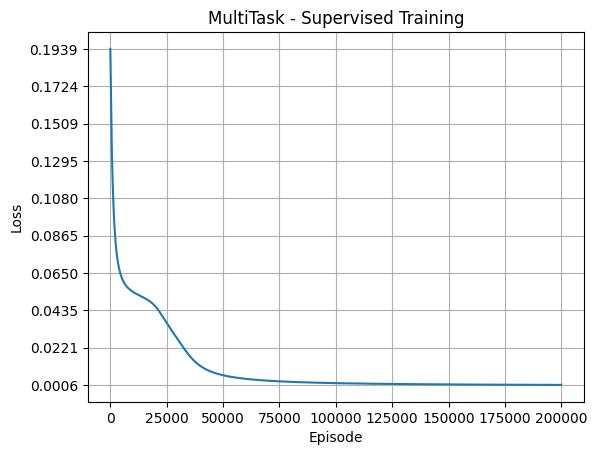

In [ ]:
single_log=plot_losses(MSE_log,'MultiTask - Supervised Training')

In [ ]:
#Reinforcement learning using REINFORCE algorithm
def reinforce_train(model, optimizer, taskData, stimulusData, reward):

    optimizer.zero_grad()

    _, outputs = model(taskData, stimulusData)
    log_probs = torch.log(outputs.squeeze(0))

    # REINFORCE loss
    loss = -log_probs * reward
    loss = loss.mean()
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
#Reinforce traning Loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Define the Optimizer
# Define training loop
def train_Rein(model, optimizer, train_task, train_stimulus, train_target, num_episodes=1000, log_interval=1):
    losses = []  # To store losses at each episode
    for episode in range(1, num_episodes + 1):

        # Forward pass
        _, outputs = model(train_task, train_stimulus)

        # Define reward
        reward = torch.sum(outputs * train_target)

        # Train using REINFORCE
        loss = reinforce_train(model, optimizer, train_task, train_stimulus, reward)
        losses.append(loss)
        #Logging
        if episode % log_interval == 0:
            print(f"Episode {episode}/{num_episodes} | Loss: {loss:.3f}")
    return losses

In [ ]:
# Train the model with reinforce
losses=train_Rein(model, optimizer, train_task, train_stimulus, train_target, num_episodes=1000, log_interval=1)

Episode 1/1000 | Loss: 221.426
Episode 2/1000 | Loss: 219.477
Episode 3/1000 | Loss: 217.541
Episode 4/1000 | Loss: 215.619
Episode 5/1000 | Loss: 213.710
Episode 6/1000 | Loss: 211.812
Episode 7/1000 | Loss: 209.923
Episode 8/1000 | Loss: 208.041
Episode 9/1000 | Loss: 206.162
Episode 10/1000 | Loss: 204.285
Episode 11/1000 | Loss: 202.409
Episode 12/1000 | Loss: 200.532
Episode 13/1000 | Loss: 198.653
Episode 14/1000 | Loss: 196.772
Episode 15/1000 | Loss: 194.888
Episode 16/1000 | Loss: 193.000
Episode 17/1000 | Loss: 191.109
Episode 18/1000 | Loss: 189.215
Episode 19/1000 | Loss: 187.316
Episode 20/1000 | Loss: 185.413
Episode 21/1000 | Loss: 183.505
Episode 22/1000 | Loss: 181.593
Episode 23/1000 | Loss: 179.675
Episode 24/1000 | Loss: 177.753
Episode 25/1000 | Loss: 175.825
Episode 26/1000 | Loss: 173.892
Episode 27/1000 | Loss: 171.954
Episode 28/1000 | Loss: 170.010
Episode 29/1000 | Loss: 168.060
Episode 30/1000 | Loss: 166.105
Episode 31/1000 | Loss: 164.145
Episode 32/1000 |

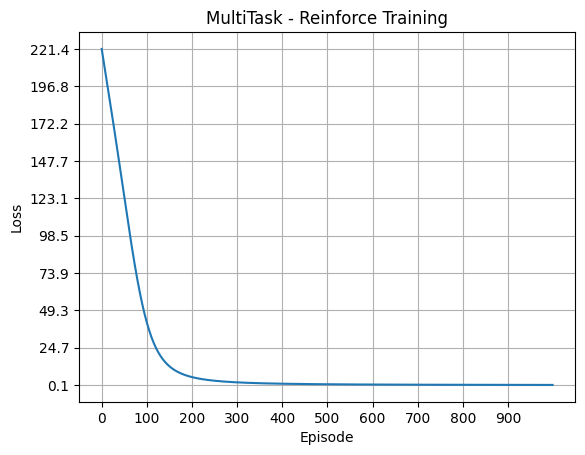

In [ ]:
Reinforce_log= plot_losses(losses, "MultiTask - Reinforce Training")

In [ ]:
#Define Evalutae function
def evaluate(model, taskData_V, stimulusData_V, targetData_V):
    model.eval()
    with torch.no_grad():
        _, val_output = model(taskData_V, stimulusData_V)
        criterion = nn.MSELoss()
        val_loss = criterion(val_output, targetData_V).item()
    model.train()
    return val_loss, val_output

In [ ]:
evaluate(model, taskData_V, stimulusData_V, targetData_V)

0.20421773195266724

In [ ]:
#Define multiple simulations
def run_simulations(n_simulations=100, num_episodes=1000, log_interval=100):
    all_losses = []

    for i in tqdm(range(n_simulations)):
        model = Model()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        training_set, validation_set = generate_dataset_multitask(split_ratio=0.7)
        train_stimulus, train_task, train_target = training_set

        losses = train_Rein(model, optimizer, train_task, train_stimulus, train_target, num_episodes, log_interval)

        if len(losses) > 0:
            print(f"Simulation {i+1}: First few losses: {losses[:5]}")

        all_losses.append(losses)

    print(f"Total simulations run: {len(all_losses)}")
    return all_losses

In [ ]:
def calculate_mean_and_standard_error(losses):
    min_length = min(len(loss) for loss in losses)
    trimmed_losses = [loss[:min_length] for loss in losses if loss is not None]  # Exclude None losses
    losses_array = numpy.array(trimmed_losses) # convert to numpy array
    mean_losses = numpy.mean(losses_array, axis=0)  #calculate mean
    std_err_losses = numpy.std(losses_array, axis=0) / numpy.sqrt(losses_array.shape[0]) #calculate standard deviation
    return mean_losses, std_err_losses

In [ ]:
def plot_standard_error(mean_losses, std_err_losses, title):
    epochs = range(len(mean_losses))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, mean_losses, label='Mean Loss', linewidth=2)
    visible_std_err_losses = std_err_losses *100  # Scaling the standard error for visibility
    plt.fill_between(epochs, mean_losses - visible_std_err_losses, mean_losses + visible_std_err_losses, color='b', alpha=0.3, label='Standard Error (Scaled)')
    plt.xlabel('Epochs / Episodes')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{title.replace(" ", "_").lower()}_learning_curve_with_standard_error.png')
    plt.show()


In [ ]:
all_losses = run_simulations(n_simulations=100, num_episodes=1000, log_interval=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Episode 100/1000 | Loss: 36.672
Episode 200/1000 | Loss: 4.770
Episode 300/1000 | Loss: 1.655
Episode 400/1000 | Loss: 0.838
Episode 500/1000 | Loss: 0.508
Episode 600/1000 | Loss: 0.341
Episode 700/1000 | Loss: 0.245
Episode 800/1000 | Loss: 0.185
Episode 900/1000 | Loss: 0.144


  1%|          | 1/100 [00:02<04:52,  2.95s/it]

Episode 1000/1000 | Loss: 0.116
Simulation 1: First few losses: [203.56072998046875, 201.70947265625, 199.8605194091797, 198.0137481689453, 196.1691131591797]
Episode 100/1000 | Loss: 43.294
Episode 200/1000 | Loss: 5.581
Episode 300/1000 | Loss: 1.906
Episode 400/1000 | Loss: 0.958
Episode 500/1000 | Loss: 0.578
Episode 600/1000 | Loss: 0.387
Episode 700/1000 | Loss: 0.277
Episode 800/1000 | Loss: 0.208
Episode 900/1000 | Loss: 0.162


  2%|▏         | 2/100 [00:06<05:21,  3.28s/it]

Episode 1000/1000 | Loss: 0.130
Simulation 2: First few losses: [223.35902404785156, 221.39462280273438, 219.43179321289062, 217.4707489013672, 215.51173400878906]
Episode 100/1000 | Loss: 35.491
Episode 200/1000 | Loss: 4.768
Episode 300/1000 | Loss: 1.666
Episode 400/1000 | Loss: 0.845
Episode 500/1000 | Loss: 0.512
Episode 600/1000 | Loss: 0.344
Episode 700/1000 | Loss: 0.248
Episode 800/1000 | Loss: 0.186
Episode 900/1000 | Loss: 0.145


  3%|▎         | 3/100 [00:10<05:34,  3.45s/it]

Episode 1000/1000 | Loss: 0.117
Simulation 3: First few losses: [201.5271759033203, 199.69110107421875, 197.85572814941406, 196.02072143554688, 194.18588256835938]
Episode 100/1000 | Loss: 44.617
Episode 200/1000 | Loss: 5.583
Episode 300/1000 | Loss: 1.889
Episode 400/1000 | Loss: 0.946
Episode 500/1000 | Loss: 0.569
Episode 600/1000 | Loss: 0.381
Episode 700/1000 | Loss: 0.273
Episode 800/1000 | Loss: 0.205
Episode 900/1000 | Loss: 0.160


  4%|▍         | 4/100 [00:13<05:11,  3.25s/it]

Episode 1000/1000 | Loss: 0.128
Simulation 4: First few losses: [225.9840850830078, 223.9352569580078, 221.9156494140625, 219.9232177734375, 217.9541473388672]
Episode 100/1000 | Loss: 39.466
Episode 200/1000 | Loss: 5.107
Episode 300/1000 | Loss: 1.774
Episode 400/1000 | Loss: 0.899
Episode 500/1000 | Loss: 0.545
Episode 600/1000 | Loss: 0.366
Episode 700/1000 | Loss: 0.263
Episode 800/1000 | Loss: 0.199
Episode 900/1000 | Loss: 0.155


  5%|▌         | 5/100 [00:16<04:58,  3.14s/it]

Episode 1000/1000 | Loss: 0.124
Simulation 5: First few losses: [217.5751953125, 215.628662109375, 213.6956024169922, 211.77503967285156, 209.8651885986328]
Episode 100/1000 | Loss: 39.285
Episode 200/1000 | Loss: 5.164
Episode 300/1000 | Loss: 1.812
Episode 400/1000 | Loss: 0.923
Episode 500/1000 | Loss: 0.561
Episode 600/1000 | Loss: 0.378
Episode 700/1000 | Loss: 0.272
Episode 800/1000 | Loss: 0.206
Episode 900/1000 | Loss: 0.161


  6%|▌         | 6/100 [00:19<05:03,  3.22s/it]

Episode 1000/1000 | Loss: 0.129
Simulation 6: First few losses: [219.92596435546875, 217.9773406982422, 216.03558349609375, 214.0977020263672, 212.1623992919922]
Episode 100/1000 | Loss: 36.827
Episode 200/1000 | Loss: 4.733
Episode 300/1000 | Loss: 1.623
Episode 400/1000 | Loss: 0.818
Episode 500/1000 | Loss: 0.494
Episode 600/1000 | Loss: 0.331
Episode 700/1000 | Loss: 0.238
Episode 800/1000 | Loss: 0.179
Episode 900/1000 | Loss: 0.139


  7%|▋         | 7/100 [00:23<05:15,  3.39s/it]

Episode 1000/1000 | Loss: 0.112
Simulation 7: First few losses: [198.66354370117188, 196.87356567382812, 195.0869140625, 193.30360412597656, 191.5235595703125]
Episode 100/1000 | Loss: 36.857
Episode 200/1000 | Loss: 4.815
Episode 300/1000 | Loss: 1.665
Episode 400/1000 | Loss: 0.842
Episode 500/1000 | Loss: 0.509
Episode 600/1000 | Loss: 0.342
Episode 700/1000 | Loss: 0.246
Episode 800/1000 | Loss: 0.185
Episode 900/1000 | Loss: 0.144


  8%|▊         | 8/100 [00:26<05:11,  3.38s/it]

Episode 1000/1000 | Loss: 0.116
Simulation 8: First few losses: [203.39967346191406, 201.53277587890625, 199.66957092285156, 197.80982971191406, 195.9532470703125]
Episode 100/1000 | Loss: 35.468
Episode 200/1000 | Loss: 4.776
Episode 300/1000 | Loss: 1.671
Episode 400/1000 | Loss: 0.847
Episode 500/1000 | Loss: 0.513
Episode 600/1000 | Loss: 0.345
Episode 700/1000 | Loss: 0.248
Episode 800/1000 | Loss: 0.186
Episode 900/1000 | Loss: 0.145


  9%|▉         | 9/100 [00:34<07:24,  4.89s/it]

Episode 1000/1000 | Loss: 0.116
Simulation 9: First few losses: [203.06883239746094, 201.1754608154297, 199.29031372070312, 197.4102325439453, 195.53334045410156]
Episode 100/1000 | Loss: 40.341
Episode 200/1000 | Loss: 5.284
Episode 300/1000 | Loss: 1.805
Episode 400/1000 | Loss: 0.906
Episode 500/1000 | Loss: 0.545
Episode 600/1000 | Loss: 0.365
Episode 700/1000 | Loss: 0.261
Episode 800/1000 | Loss: 0.196
Episode 900/1000 | Loss: 0.153


 10%|█         | 10/100 [00:38<06:43,  4.48s/it]

Episode 1000/1000 | Loss: 0.122
Simulation 10: First few losses: [212.10287475585938, 210.16856384277344, 208.23922729492188, 206.314697265625, 204.39483642578125]
Episode 100/1000 | Loss: 35.222
Episode 200/1000 | Loss: 4.821
Episode 300/1000 | Loss: 1.673
Episode 400/1000 | Loss: 0.845
Episode 500/1000 | Loss: 0.511
Episode 600/1000 | Loss: 0.343
Episode 700/1000 | Loss: 0.246
Episode 800/1000 | Loss: 0.185
Episode 900/1000 | Loss: 0.145


 11%|█         | 11/100 [00:41<05:58,  4.02s/it]

Episode 1000/1000 | Loss: 0.116
Simulation 11: First few losses: [193.45013427734375, 191.57196044921875, 189.69839477539062, 187.8294677734375, 185.96517944335938]
Episode 100/1000 | Loss: 35.136
Episode 200/1000 | Loss: 4.717
Episode 300/1000 | Loss: 1.643
Episode 400/1000 | Loss: 0.832
Episode 500/1000 | Loss: 0.503
Episode 600/1000 | Loss: 0.338
Episode 700/1000 | Loss: 0.242
Episode 800/1000 | Loss: 0.182
Episode 900/1000 | Loss: 0.142


 12%|█▏        | 12/100 [00:44<05:26,  3.71s/it]

Episode 1000/1000 | Loss: 0.114
Simulation 12: First few losses: [199.02676391601562, 197.2102813720703, 195.39366149902344, 193.57716369628906, 191.76068115234375]
Episode 100/1000 | Loss: 39.295
Episode 200/1000 | Loss: 5.202
Episode 300/1000 | Loss: 1.802
Episode 400/1000 | Loss: 0.912
Episode 500/1000 | Loss: 0.552
Episode 600/1000 | Loss: 0.371
Episode 700/1000 | Loss: 0.267
Episode 800/1000 | Loss: 0.201
Episode 900/1000 | Loss: 0.157


 13%|█▎        | 13/100 [00:48<05:26,  3.75s/it]

Episode 1000/1000 | Loss: 0.126
Simulation 13: First few losses: [212.9144287109375, 210.9365997314453, 208.98020935058594, 207.0414276123047, 205.11602783203125]
Episode 100/1000 | Loss: 39.190
Episode 200/1000 | Loss: 4.936
Episode 300/1000 | Loss: 1.711
Episode 400/1000 | Loss: 0.867
Episode 500/1000 | Loss: 0.526
Episode 600/1000 | Loss: 0.353
Episode 700/1000 | Loss: 0.254
Episode 800/1000 | Loss: 0.192
Episode 900/1000 | Loss: 0.149


 14%|█▍        | 14/100 [00:51<05:10,  3.61s/it]

Episode 1000/1000 | Loss: 0.120
Simulation 14: First few losses: [216.03311157226562, 214.1931915283203, 212.35260009765625, 210.51129150390625, 208.66909790039062]
Episode 100/1000 | Loss: 35.536
Episode 200/1000 | Loss: 4.711
Episode 300/1000 | Loss: 1.640
Episode 400/1000 | Loss: 0.830
Episode 500/1000 | Loss: 0.503
Episode 600/1000 | Loss: 0.337
Episode 700/1000 | Loss: 0.242
Episode 800/1000 | Loss: 0.183
Episode 900/1000 | Loss: 0.142


 15%|█▌        | 15/100 [00:54<04:51,  3.43s/it]

Episode 1000/1000 | Loss: 0.114
Simulation 15: First few losses: [201.18521118164062, 199.33265686035156, 197.48106384277344, 195.63050842285156, 193.78121948242188]
Episode 100/1000 | Loss: 43.334
Episode 200/1000 | Loss: 5.420
Episode 300/1000 | Loss: 1.849
Episode 400/1000 | Loss: 0.929
Episode 500/1000 | Loss: 0.560
Episode 600/1000 | Loss: 0.375
Episode 700/1000 | Loss: 0.269
Episode 800/1000 | Loss: 0.202
Episode 900/1000 | Loss: 0.158


 16%|█▌        | 16/100 [00:57<04:36,  3.29s/it]

Episode 1000/1000 | Loss: 0.126
Simulation 16: First few losses: [225.80853271484375, 223.7556915283203, 221.72776794433594, 219.72406005859375, 217.74331665039062]
Episode 100/1000 | Loss: 34.728
Episode 200/1000 | Loss: 4.682
Episode 300/1000 | Loss: 1.638
Episode 400/1000 | Loss: 0.832
Episode 500/1000 | Loss: 0.504
Episode 600/1000 | Loss: 0.339
Episode 700/1000 | Loss: 0.244
Episode 800/1000 | Loss: 0.184
Episode 900/1000 | Loss: 0.143


 17%|█▋        | 17/100 [01:00<04:38,  3.35s/it]

Episode 1000/1000 | Loss: 0.115
Simulation 17: First few losses: [198.95932006835938, 197.06256103515625, 195.171142578125, 193.28465270996094, 191.4026336669922]
Episode 100/1000 | Loss: 34.853
Episode 200/1000 | Loss: 4.721
Episode 300/1000 | Loss: 1.658
Episode 400/1000 | Loss: 0.843
Episode 500/1000 | Loss: 0.511
Episode 600/1000 | Loss: 0.344
Episode 700/1000 | Loss: 0.247
Episode 800/1000 | Loss: 0.186
Episode 900/1000 | Loss: 0.145


 18%|█▊        | 18/100 [01:04<04:41,  3.43s/it]

Episode 1000/1000 | Loss: 0.116
Simulation 18: First few losses: [201.93783569335938, 200.05540466308594, 198.1754608154297, 196.29788208007812, 194.42234802246094]
Episode 100/1000 | Loss: 36.755
Episode 200/1000 | Loss: 4.809
Episode 300/1000 | Loss: 1.655
Episode 400/1000 | Loss: 0.835
Episode 500/1000 | Loss: 0.504
Episode 600/1000 | Loss: 0.338
Episode 700/1000 | Loss: 0.243
Episode 800/1000 | Loss: 0.183
Episode 900/1000 | Loss: 0.142


 19%|█▉        | 19/100 [01:07<04:26,  3.29s/it]

Episode 1000/1000 | Loss: 0.114
Simulation 19: First few losses: [199.792724609375, 197.9478302001953, 196.10633850097656, 194.2681884765625, 192.4332733154297]
Episode 100/1000 | Loss: 36.342
Episode 200/1000 | Loss: 4.696
Episode 300/1000 | Loss: 1.646
Episode 400/1000 | Loss: 0.839
Episode 500/1000 | Loss: 0.510
Episode 600/1000 | Loss: 0.344
Episode 700/1000 | Loss: 0.248
Episode 800/1000 | Loss: 0.187
Episode 900/1000 | Loss: 0.146


 20%|██        | 20/100 [01:10<04:18,  3.23s/it]

Episode 1000/1000 | Loss: 0.117
Simulation 20: First few losses: [209.8629913330078, 208.00912475585938, 206.15528869628906, 204.30149841308594, 202.44760131835938]
Episode 100/1000 | Loss: 39.884
Episode 200/1000 | Loss: 5.096
Episode 300/1000 | Loss: 1.749
Episode 400/1000 | Loss: 0.880
Episode 500/1000 | Loss: 0.531
Episode 600/1000 | Loss: 0.356
Episode 700/1000 | Loss: 0.255
Episode 800/1000 | Loss: 0.192
Episode 900/1000 | Loss: 0.150


 21%|██        | 21/100 [01:13<04:18,  3.27s/it]

Episode 1000/1000 | Loss: 0.120
Simulation 21: First few losses: [213.266845703125, 211.3162841796875, 209.38111877441406, 207.46128845214844, 205.55618286132812]
Episode 100/1000 | Loss: 35.867
Episode 200/1000 | Loss: 4.774
Episode 300/1000 | Loss: 1.656
Episode 400/1000 | Loss: 0.837
Episode 500/1000 | Loss: 0.506
Episode 600/1000 | Loss: 0.339
Episode 700/1000 | Loss: 0.244
Episode 800/1000 | Loss: 0.183
Episode 900/1000 | Loss: 0.143


 22%|██▏       | 22/100 [01:17<04:27,  3.42s/it]

Episode 1000/1000 | Loss: 0.114
Simulation 22: First few losses: [200.16183471679688, 198.30860900878906, 196.45864868164062, 194.6116943359375, 192.7676544189453]
Episode 100/1000 | Loss: 41.064
Episode 200/1000 | Loss: 5.188
Episode 300/1000 | Loss: 1.781
Episode 400/1000 | Loss: 0.899
Episode 500/1000 | Loss: 0.544
Episode 600/1000 | Loss: 0.365
Episode 700/1000 | Loss: 0.262
Episode 800/1000 | Loss: 0.198
Episode 900/1000 | Loss: 0.154


 23%|██▎       | 23/100 [01:20<04:16,  3.33s/it]

Episode 1000/1000 | Loss: 0.124
Simulation 23: First few losses: [218.01539611816406, 216.05870056152344, 214.11911010742188, 212.19613647460938, 210.28866577148438]
Episode 100/1000 | Loss: 35.343
Episode 200/1000 | Loss: 4.639
Episode 300/1000 | Loss: 1.624
Episode 400/1000 | Loss: 0.826
Episode 500/1000 | Loss: 0.501
Episode 600/1000 | Loss: 0.337
Episode 700/1000 | Loss: 0.243
Episode 800/1000 | Loss: 0.183
Episode 900/1000 | Loss: 0.143


 24%|██▍       | 24/100 [01:24<04:11,  3.30s/it]

Episode 1000/1000 | Loss: 0.115
Simulation 24: First few losses: [203.92706298828125, 202.10304260253906, 200.27890014648438, 198.45469665527344, 196.63052368164062]
Episode 100/1000 | Loss: 39.617
Episode 200/1000 | Loss: 5.104
Episode 300/1000 | Loss: 1.766
Episode 400/1000 | Loss: 0.894
Episode 500/1000 | Loss: 0.541
Episode 600/1000 | Loss: 0.364
Episode 700/1000 | Loss: 0.262
Episode 800/1000 | Loss: 0.197
Episode 900/1000 | Loss: 0.154


 25%|██▌       | 25/100 [01:27<04:11,  3.36s/it]

Episode 1000/1000 | Loss: 0.123
Simulation 25: First few losses: [215.50462341308594, 213.64625549316406, 211.78900146484375, 209.9322509765625, 208.0754852294922]
Episode 100/1000 | Loss: 38.698
Episode 200/1000 | Loss: 5.215
Episode 300/1000 | Loss: 1.792
Episode 400/1000 | Loss: 0.901
Episode 500/1000 | Loss: 0.543
Episode 600/1000 | Loss: 0.364
Episode 700/1000 | Loss: 0.261
Episode 800/1000 | Loss: 0.196
Episode 900/1000 | Loss: 0.153


 26%|██▌       | 26/100 [01:31<04:17,  3.49s/it]

Episode 1000/1000 | Loss: 0.122
Simulation 26: First few losses: [205.724365234375, 203.7698974609375, 201.8204345703125, 199.87588500976562, 197.9362030029297]
Episode 100/1000 | Loss: 41.051
Episode 200/1000 | Loss: 5.170
Episode 300/1000 | Loss: 1.767
Episode 400/1000 | Loss: 0.889
Episode 500/1000 | Loss: 0.537
Episode 600/1000 | Loss: 0.360
Episode 700/1000 | Loss: 0.258
Episode 800/1000 | Loss: 0.194
Episode 900/1000 | Loss: 0.151


 27%|██▋       | 27/100 [01:34<04:14,  3.49s/it]

Episode 1000/1000 | Loss: 0.121
Simulation 27: First few losses: [216.04296875, 214.06365966796875, 212.10733032226562, 210.17153930664062, 208.25363159179688]
Episode 100/1000 | Loss: 40.239
Episode 200/1000 | Loss: 5.052
Episode 300/1000 | Loss: 1.735
Episode 400/1000 | Loss: 0.876
Episode 500/1000 | Loss: 0.529
Episode 600/1000 | Loss: 0.355
Episode 700/1000 | Loss: 0.255
Episode 800/1000 | Loss: 0.192
Episode 900/1000 | Loss: 0.150


 28%|██▊       | 28/100 [01:37<04:00,  3.34s/it]

Episode 1000/1000 | Loss: 0.120
Simulation 28: First few losses: [213.4431915283203, 211.51995849609375, 209.61111450195312, 207.71633911132812, 205.8352813720703]
Episode 100/1000 | Loss: 37.435
Episode 200/1000 | Loss: 4.991
Episode 300/1000 | Loss: 1.727
Episode 400/1000 | Loss: 0.873
Episode 500/1000 | Loss: 0.528
Episode 600/1000 | Loss: 0.354
Episode 700/1000 | Loss: 0.255
Episode 800/1000 | Loss: 0.192
Episode 900/1000 | Loss: 0.150


 29%|██▉       | 29/100 [01:41<04:00,  3.39s/it]

Episode 1000/1000 | Loss: 0.120
Simulation 29: First few losses: [203.79769897460938, 201.8953857421875, 200.0007781982422, 198.11204528808594, 196.22850036621094]
Episode 100/1000 | Loss: 36.858
Episode 200/1000 | Loss: 4.818
Episode 300/1000 | Loss: 1.662
Episode 400/1000 | Loss: 0.838
Episode 500/1000 | Loss: 0.506
Episode 600/1000 | Loss: 0.339
Episode 700/1000 | Loss: 0.243
Episode 800/1000 | Loss: 0.183
Episode 900/1000 | Loss: 0.143


 30%|███       | 30/100 [01:45<04:06,  3.53s/it]

Episode 1000/1000 | Loss: 0.114
Simulation 30: First few losses: [202.64649963378906, 200.81631469726562, 198.9878387451172, 197.16104125976562, 195.3358612060547]
Episode 100/1000 | Loss: 38.620
Episode 200/1000 | Loss: 5.088
Episode 300/1000 | Loss: 1.758
Episode 400/1000 | Loss: 0.889
Episode 500/1000 | Loss: 0.538
Episode 600/1000 | Loss: 0.361
Episode 700/1000 | Loss: 0.259
Episode 800/1000 | Loss: 0.195
Episode 900/1000 | Loss: 0.152


 31%|███       | 31/100 [01:48<03:53,  3.38s/it]

Episode 1000/1000 | Loss: 0.122
Simulation 31: First few losses: [209.66387939453125, 207.71652221679688, 205.7820281982422, 203.85736083984375, 201.93975830078125]
Episode 100/1000 | Loss: 43.112
Episode 200/1000 | Loss: 5.332
Episode 300/1000 | Loss: 1.814
Episode 400/1000 | Loss: 0.912
Episode 500/1000 | Loss: 0.550
Episode 600/1000 | Loss: 0.369
Episode 700/1000 | Loss: 0.265
Episode 800/1000 | Loss: 0.199
Episode 900/1000 | Loss: 0.155


 32%|███▏      | 32/100 [01:51<03:42,  3.28s/it]

Episode 1000/1000 | Loss: 0.124
Simulation 32: First few losses: [221.88807678222656, 219.80340576171875, 217.7542266845703, 215.73814392089844, 213.75225830078125]
Episode 100/1000 | Loss: 42.499
Episode 200/1000 | Loss: 5.383
Episode 300/1000 | Loss: 1.816
Episode 400/1000 | Loss: 0.908
Episode 500/1000 | Loss: 0.546
Episode 600/1000 | Loss: 0.365
Episode 700/1000 | Loss: 0.261
Episode 800/1000 | Loss: 0.196
Episode 900/1000 | Loss: 0.153


 33%|███▎      | 33/100 [01:54<03:45,  3.36s/it]

Episode 1000/1000 | Loss: 0.122
Simulation 33: First few losses: [215.56568908691406, 213.61326599121094, 211.667236328125, 209.72703552246094, 207.7921600341797]
Episode 100/1000 | Loss: 43.010
Episode 200/1000 | Loss: 5.279
Episode 300/1000 | Loss: 1.790
Episode 400/1000 | Loss: 0.899
Episode 500/1000 | Loss: 0.542
Episode 600/1000 | Loss: 0.363
Episode 700/1000 | Loss: 0.260
Episode 800/1000 | Loss: 0.196
Episode 900/1000 | Loss: 0.153


 34%|███▍      | 34/100 [01:58<03:52,  3.53s/it]

Episode 1000/1000 | Loss: 0.122
Simulation 34: First few losses: [220.07522583007812, 218.14439392089844, 216.22914123535156, 214.32940673828125, 212.44496154785156]
Episode 100/1000 | Loss: 41.558
Episode 200/1000 | Loss: 5.309
Episode 300/1000 | Loss: 1.840
Episode 400/1000 | Loss: 0.933
Episode 500/1000 | Loss: 0.566
Episode 600/1000 | Loss: 0.381
Episode 700/1000 | Loss: 0.274
Episode 800/1000 | Loss: 0.207
Episode 900/1000 | Loss: 0.161


 35%|███▌      | 35/100 [02:01<03:38,  3.36s/it]

Episode 1000/1000 | Loss: 0.129
Simulation 35: First few losses: [226.1315155029297, 224.08987426757812, 222.06375122070312, 220.05288696289062, 218.0568389892578]
Episode 100/1000 | Loss: 36.735
Episode 200/1000 | Loss: 4.738
Episode 300/1000 | Loss: 1.635
Episode 400/1000 | Loss: 0.826
Episode 500/1000 | Loss: 0.500
Episode 600/1000 | Loss: 0.336
Episode 700/1000 | Loss: 0.242
Episode 800/1000 | Loss: 0.182
Episode 900/1000 | Loss: 0.142


 36%|███▌      | 36/100 [02:04<03:28,  3.25s/it]

Episode 1000/1000 | Loss: 0.114
Simulation 36: First few losses: [201.78854370117188, 199.93653869628906, 198.08981323242188, 196.2480926513672, 194.41110229492188]
Episode 100/1000 | Loss: 39.759
Episode 200/1000 | Loss: 5.033
Episode 300/1000 | Loss: 1.719
Episode 400/1000 | Loss: 0.864
Episode 500/1000 | Loss: 0.521
Episode 600/1000 | Loss: 0.349
Episode 700/1000 | Loss: 0.251
Episode 800/1000 | Loss: 0.188
Episode 900/1000 | Loss: 0.147


 37%|███▋      | 37/100 [02:08<03:27,  3.29s/it]

Episode 1000/1000 | Loss: 0.118
Simulation 37: First few losses: [210.24441528320312, 208.38316345214844, 206.52491760253906, 204.66976928710938, 202.8177032470703]
Episode 100/1000 | Loss: 36.506
Episode 200/1000 | Loss: 4.805
Episode 300/1000 | Loss: 1.679
Episode 400/1000 | Loss: 0.853
Episode 500/1000 | Loss: 0.517
Episode 600/1000 | Loss: 0.348
Episode 700/1000 | Loss: 0.250
Episode 800/1000 | Loss: 0.189
Episode 900/1000 | Loss: 0.147


 38%|███▊      | 38/100 [02:11<03:34,  3.47s/it]

Episode 1000/1000 | Loss: 0.118
Simulation 38: First few losses: [206.82565307617188, 204.97328186035156, 203.1306610107422, 201.2957305908203, 199.4658966064453]
Episode 100/1000 | Loss: 38.710
Episode 200/1000 | Loss: 5.188
Episode 300/1000 | Loss: 1.792
Episode 400/1000 | Loss: 0.904
Episode 500/1000 | Loss: 0.546
Episode 600/1000 | Loss: 0.366
Episode 700/1000 | Loss: 0.263
Episode 800/1000 | Loss: 0.198
Episode 900/1000 | Loss: 0.154


 39%|███▉      | 39/100 [02:16<04:00,  3.94s/it]

Episode 1000/1000 | Loss: 0.123
Simulation 39: First few losses: [208.42750549316406, 206.4738006591797, 204.5272216796875, 202.5872039794922, 200.6529541015625]
Episode 100/1000 | Loss: 37.280
Episode 200/1000 | Loss: 4.924
Episode 300/1000 | Loss: 1.726
Episode 400/1000 | Loss: 0.879
Episode 500/1000 | Loss: 0.534
Episode 600/1000 | Loss: 0.360
Episode 700/1000 | Loss: 0.259
Episode 800/1000 | Loss: 0.195
Episode 900/1000 | Loss: 0.152


 40%|████      | 40/100 [02:19<03:38,  3.64s/it]

Episode 1000/1000 | Loss: 0.122
Simulation 40: First few losses: [212.35203552246094, 210.45965576171875, 208.5664825439453, 206.67239379882812, 204.77731323242188]
Episode 100/1000 | Loss: 35.534
Episode 200/1000 | Loss: 4.761
Episode 300/1000 | Loss: 1.666
Episode 400/1000 | Loss: 0.847
Episode 500/1000 | Loss: 0.514
Episode 600/1000 | Loss: 0.346
Episode 700/1000 | Loss: 0.249
Episode 800/1000 | Loss: 0.188
Episode 900/1000 | Loss: 0.146


 41%|████      | 41/100 [02:24<03:43,  3.79s/it]

Episode 1000/1000 | Loss: 0.117
Simulation 41: First few losses: [201.5851287841797, 199.72361755371094, 197.86390686035156, 196.00584411621094, 194.1493682861328]
Episode 100/1000 | Loss: 35.168
Episode 200/1000 | Loss: 4.736
Episode 300/1000 | Loss: 1.643
Episode 400/1000 | Loss: 0.830
Episode 500/1000 | Loss: 0.502
Episode 600/1000 | Loss: 0.336
Episode 700/1000 | Loss: 0.241
Episode 800/1000 | Loss: 0.182
Episode 900/1000 | Loss: 0.142


 42%|████▏     | 42/100 [02:26<03:25,  3.55s/it]

Episode 1000/1000 | Loss: 0.113
Simulation 42: First few losses: [198.1953887939453, 196.31719970703125, 194.44235229492188, 192.57070922851562, 190.70233154296875]
Episode 100/1000 | Loss: 36.441
Episode 200/1000 | Loss: 4.817
Episode 300/1000 | Loss: 1.672
Episode 400/1000 | Loss: 0.847
Episode 500/1000 | Loss: 0.513
Episode 600/1000 | Loss: 0.345
Episode 700/1000 | Loss: 0.248
Episode 800/1000 | Loss: 0.187
Episode 900/1000 | Loss: 0.146


 43%|████▎     | 43/100 [02:29<03:11,  3.36s/it]

Episode 1000/1000 | Loss: 0.117
Simulation 43: First few losses: [200.60842895507812, 198.777587890625, 196.94874572753906, 195.12168884277344, 193.2963104248047]
Episode 100/1000 | Loss: 42.561
Episode 200/1000 | Loss: 5.422
Episode 300/1000 | Loss: 1.855
Episode 400/1000 | Loss: 0.933
Episode 500/1000 | Loss: 0.563
Episode 600/1000 | Loss: 0.378
Episode 700/1000 | Loss: 0.271
Episode 800/1000 | Loss: 0.204
Episode 900/1000 | Loss: 0.159


 44%|████▍     | 44/100 [02:32<03:01,  3.24s/it]

Episode 1000/1000 | Loss: 0.127
Simulation 44: First few losses: [222.469482421875, 220.50506591796875, 218.55691528320312, 216.61965942382812, 214.68966674804688]
Episode 100/1000 | Loss: 35.299
Episode 200/1000 | Loss: 4.785
Episode 300/1000 | Loss: 1.657
Episode 400/1000 | Loss: 0.837
Episode 500/1000 | Loss: 0.505
Episode 600/1000 | Loss: 0.339
Episode 700/1000 | Loss: 0.243
Episode 800/1000 | Loss: 0.183
Episode 900/1000 | Loss: 0.143


 45%|████▌     | 45/100 [02:36<03:07,  3.41s/it]

Episode 1000/1000 | Loss: 0.114
Simulation 45: First few losses: [194.78367614746094, 192.90847778320312, 191.03794860839844, 189.17222595214844, 187.3111572265625]
Episode 100/1000 | Loss: 39.657
Episode 200/1000 | Loss: 5.032
Episode 300/1000 | Loss: 1.710
Episode 400/1000 | Loss: 0.859
Episode 500/1000 | Loss: 0.518
Episode 600/1000 | Loss: 0.347
Episode 700/1000 | Loss: 0.249
Episode 800/1000 | Loss: 0.187
Episode 900/1000 | Loss: 0.146


 46%|████▌     | 46/100 [02:39<03:01,  3.36s/it]

Episode 1000/1000 | Loss: 0.117
Simulation 46: First few losses: [204.7625732421875, 202.94345092773438, 201.1276092529297, 199.3148956298828, 197.5052947998047]
Episode 100/1000 | Loss: 40.823
Episode 200/1000 | Loss: 5.207
Episode 300/1000 | Loss: 1.757
Episode 400/1000 | Loss: 0.878
Episode 500/1000 | Loss: 0.527
Episode 600/1000 | Loss: 0.352
Episode 700/1000 | Loss: 0.252
Episode 800/1000 | Loss: 0.189
Episode 900/1000 | Loss: 0.147


 47%|████▋     | 47/100 [02:42<02:52,  3.25s/it]

Episode 1000/1000 | Loss: 0.118
Simulation 47: First few losses: [208.4251251220703, 206.53277587890625, 204.6471710205078, 202.7677459716797, 200.89402770996094]
Episode 100/1000 | Loss: 45.127
Episode 200/1000 | Loss: 5.377
Episode 300/1000 | Loss: 1.826
Episode 400/1000 | Loss: 0.919
Episode 500/1000 | Loss: 0.556
Episode 600/1000 | Loss: 0.373
Episode 700/1000 | Loss: 0.268
Episode 800/1000 | Loss: 0.202
Episode 900/1000 | Loss: 0.158


 48%|████▊     | 48/100 [02:45<02:44,  3.16s/it]

Episode 1000/1000 | Loss: 0.126
Simulation 48: First few losses: [230.53204345703125, 228.5682373046875, 226.62222290039062, 224.693115234375, 222.78013610839844]
Episode 100/1000 | Loss: 35.667
Episode 200/1000 | Loss: 4.886
Episode 300/1000 | Loss: 1.698
Episode 400/1000 | Loss: 0.859
Episode 500/1000 | Loss: 0.520
Episode 600/1000 | Loss: 0.349
Episode 700/1000 | Loss: 0.251
Episode 800/1000 | Loss: 0.189
Episode 900/1000 | Loss: 0.148


 49%|████▉     | 49/100 [02:49<02:45,  3.25s/it]

Episode 1000/1000 | Loss: 0.118
Simulation 49: First few losses: [197.76194763183594, 195.8404998779297, 193.92384338378906, 192.01197814941406, 190.1048126220703]
Episode 100/1000 | Loss: 34.563
Episode 200/1000 | Loss: 4.637
Episode 300/1000 | Loss: 1.634
Episode 400/1000 | Loss: 0.834
Episode 500/1000 | Loss: 0.507
Episode 600/1000 | Loss: 0.342
Episode 700/1000 | Loss: 0.246
Episode 800/1000 | Loss: 0.186
Episode 900/1000 | Loss: 0.145


 50%|█████     | 50/100 [02:53<02:49,  3.38s/it]

Episode 1000/1000 | Loss: 0.117
Simulation 50: First few losses: [201.7662811279297, 199.88230895996094, 198.00062561035156, 196.12086486816406, 194.24273681640625]
Episode 100/1000 | Loss: 35.287
Episode 200/1000 | Loss: 4.735
Episode 300/1000 | Loss: 1.636
Episode 400/1000 | Loss: 0.826
Episode 500/1000 | Loss: 0.499
Episode 600/1000 | Loss: 0.335
Episode 700/1000 | Loss: 0.241
Episode 800/1000 | Loss: 0.181
Episode 900/1000 | Loss: 0.141


 51%|█████     | 51/100 [02:55<02:38,  3.24s/it]

Episode 1000/1000 | Loss: 0.113
Simulation 51: First few losses: [193.94044494628906, 192.11376953125, 190.29046630859375, 188.47047424316406, 186.6537322998047]
Episode 100/1000 | Loss: 38.160
Episode 200/1000 | Loss: 5.018
Episode 300/1000 | Loss: 1.731
Episode 400/1000 | Loss: 0.872
Episode 500/1000 | Loss: 0.527
Episode 600/1000 | Loss: 0.353
Episode 700/1000 | Loss: 0.253
Episode 800/1000 | Loss: 0.190
Episode 900/1000 | Loss: 0.148


 52%|█████▏    | 52/100 [02:58<02:30,  3.14s/it]

Episode 1000/1000 | Loss: 0.119
Simulation 52: First few losses: [208.12709045410156, 206.24334716796875, 204.3612060546875, 202.4806671142578, 200.60169982910156]
Episode 100/1000 | Loss: 37.458
Episode 200/1000 | Loss: 4.951
Episode 300/1000 | Loss: 1.718
Episode 400/1000 | Loss: 0.869
Episode 500/1000 | Loss: 0.526
Episode 600/1000 | Loss: 0.353
Episode 700/1000 | Loss: 0.253
Episode 800/1000 | Loss: 0.191
Episode 900/1000 | Loss: 0.149


 53%|█████▎    | 53/100 [03:02<02:29,  3.18s/it]

Episode 1000/1000 | Loss: 0.119
Simulation 53: First few losses: [207.46926879882812, 205.57278442382812, 203.68441772460938, 201.80130004882812, 199.92149353027344]
Episode 100/1000 | Loss: 40.289
Episode 200/1000 | Loss: 5.037
Episode 300/1000 | Loss: 1.719
Episode 400/1000 | Loss: 0.865
Episode 500/1000 | Loss: 0.522
Episode 600/1000 | Loss: 0.350
Episode 700/1000 | Loss: 0.252
Episode 800/1000 | Loss: 0.189
Episode 900/1000 | Loss: 0.148


 54%|█████▍    | 54/100 [03:06<02:36,  3.40s/it]

Episode 1000/1000 | Loss: 0.118
Simulation 54: First few losses: [212.71981811523438, 210.8950653076172, 209.0750732421875, 207.25843811035156, 205.4444580078125]
Episode 100/1000 | Loss: 37.074
Episode 200/1000 | Loss: 4.835
Episode 300/1000 | Loss: 1.645
Episode 400/1000 | Loss: 0.825
Episode 500/1000 | Loss: 0.497
Episode 600/1000 | Loss: 0.333
Episode 700/1000 | Loss: 0.239
Episode 800/1000 | Loss: 0.179
Episode 900/1000 | Loss: 0.140


 55%|█████▌    | 55/100 [03:09<02:27,  3.27s/it]

Episode 1000/1000 | Loss: 0.112
Simulation 55: First few losses: [194.35467529296875, 192.55433654785156, 190.759033203125, 188.96868896484375, 187.1829833984375]
Episode 100/1000 | Loss: 39.884
Episode 200/1000 | Loss: 5.137
Episode 300/1000 | Loss: 1.758
Episode 400/1000 | Loss: 0.885
Episode 500/1000 | Loss: 0.534
Episode 600/1000 | Loss: 0.358
Episode 700/1000 | Loss: 0.257
Episode 800/1000 | Loss: 0.193
Episode 900/1000 | Loss: 0.151


 56%|█████▌    | 56/100 [03:11<02:19,  3.18s/it]

Episode 1000/1000 | Loss: 0.121
Simulation 56: First few losses: [210.10147094726562, 208.2215118408203, 206.3450927734375, 204.47215270996094, 202.602783203125]
Episode 100/1000 | Loss: 41.463
Episode 200/1000 | Loss: 5.251
Episode 300/1000 | Loss: 1.780
Episode 400/1000 | Loss: 0.890
Episode 500/1000 | Loss: 0.535
Episode 600/1000 | Loss: 0.357
Episode 700/1000 | Loss: 0.256
Episode 800/1000 | Loss: 0.192
Episode 900/1000 | Loss: 0.149


 57%|█████▋    | 57/100 [03:15<02:15,  3.14s/it]

Episode 1000/1000 | Loss: 0.119
Simulation 57: First few losses: [214.8997344970703, 213.05242919921875, 211.20652770996094, 209.3619384765625, 207.51856994628906]
Episode 100/1000 | Loss: 37.768
Episode 200/1000 | Loss: 4.979
Episode 300/1000 | Loss: 1.729
Episode 400/1000 | Loss: 0.876
Episode 500/1000 | Loss: 0.530
Episode 600/1000 | Loss: 0.356
Episode 700/1000 | Loss: 0.256
Episode 800/1000 | Loss: 0.193
Episode 900/1000 | Loss: 0.151


 58%|█████▊    | 58/100 [03:19<02:23,  3.41s/it]

Episode 1000/1000 | Loss: 0.121
Simulation 58: First few losses: [209.55999755859375, 207.63148498535156, 205.70814514160156, 203.7894287109375, 201.87452697753906]
Episode 100/1000 | Loss: 34.403
Episode 200/1000 | Loss: 4.696
Episode 300/1000 | Loss: 1.658
Episode 400/1000 | Loss: 0.846
Episode 500/1000 | Loss: 0.514
Episode 600/1000 | Loss: 0.346
Episode 700/1000 | Loss: 0.249
Episode 800/1000 | Loss: 0.188
Episode 900/1000 | Loss: 0.147


 59%|█████▉    | 59/100 [03:22<02:14,  3.29s/it]

Episode 1000/1000 | Loss: 0.118
Simulation 59: First few losses: [202.13006591796875, 200.24916076660156, 198.36773681640625, 196.48550415039062, 194.602294921875]
Episode 100/1000 | Loss: 35.977
Episode 200/1000 | Loss: 4.810
Episode 300/1000 | Loss: 1.674
Episode 400/1000 | Loss: 0.848
Episode 500/1000 | Loss: 0.514
Episode 600/1000 | Loss: 0.345
Episode 700/1000 | Loss: 0.248
Episode 800/1000 | Loss: 0.187
Episode 900/1000 | Loss: 0.146


 60%|██████    | 60/100 [03:25<02:09,  3.23s/it]

Episode 1000/1000 | Loss: 0.117
Simulation 60: First few losses: [202.74244689941406, 200.8299560546875, 198.92066955566406, 197.01467895507812, 195.1119384765625]
Episode 100/1000 | Loss: 40.447
Episode 200/1000 | Loss: 5.219
Episode 300/1000 | Loss: 1.777
Episode 400/1000 | Loss: 0.892
Episode 500/1000 | Loss: 0.537
Episode 600/1000 | Loss: 0.360
Episode 700/1000 | Loss: 0.258
Episode 800/1000 | Loss: 0.194
Episode 900/1000 | Loss: 0.151


 61%|██████    | 61/100 [03:28<02:03,  3.16s/it]

Episode 1000/1000 | Loss: 0.121
Simulation 61: First few losses: [211.2143096923828, 209.2604522705078, 207.32435607910156, 205.40130615234375, 203.48751831054688]
Episode 100/1000 | Loss: 35.019
Episode 200/1000 | Loss: 4.703
Episode 300/1000 | Loss: 1.633
Episode 400/1000 | Loss: 0.825
Episode 500/1000 | Loss: 0.499
Episode 600/1000 | Loss: 0.335
Episode 700/1000 | Loss: 0.240
Episode 800/1000 | Loss: 0.181
Episode 900/1000 | Loss: 0.141


 62%|██████▏   | 62/100 [03:32<02:11,  3.47s/it]

Episode 1000/1000 | Loss: 0.113
Simulation 62: First few losses: [197.29136657714844, 195.44793701171875, 193.60647583007812, 191.76690673828125, 189.9291534423828]
Episode 100/1000 | Loss: 40.185
Episode 200/1000 | Loss: 5.179
Episode 300/1000 | Loss: 1.759
Episode 400/1000 | Loss: 0.881
Episode 500/1000 | Loss: 0.530
Episode 600/1000 | Loss: 0.355
Episode 700/1000 | Loss: 0.254
Episode 800/1000 | Loss: 0.191
Episode 900/1000 | Loss: 0.149


 63%|██████▎   | 63/100 [03:35<02:02,  3.31s/it]

Episode 1000/1000 | Loss: 0.119
Simulation 63: First few losses: [209.2696533203125, 207.36618041992188, 205.46725463867188, 203.57273864746094, 201.68260192871094]
Episode 100/1000 | Loss: 38.514
Episode 200/1000 | Loss: 5.137
Episode 300/1000 | Loss: 1.794
Episode 400/1000 | Loss: 0.910
Episode 500/1000 | Loss: 0.552
Episode 600/1000 | Loss: 0.371
Episode 700/1000 | Loss: 0.266
Episode 800/1000 | Loss: 0.201
Episode 900/1000 | Loss: 0.157


 64%|██████▍   | 64/100 [03:38<01:55,  3.21s/it]

Episode 1000/1000 | Loss: 0.125
Simulation 64: First few losses: [216.3009033203125, 214.33395385742188, 212.37680053710938, 210.42681884765625, 208.4812469482422]
Episode 100/1000 | Loss: 39.188
Episode 200/1000 | Loss: 5.117
Episode 300/1000 | Loss: 1.734
Episode 400/1000 | Loss: 0.866
Episode 500/1000 | Loss: 0.520
Episode 600/1000 | Loss: 0.348
Episode 700/1000 | Loss: 0.249
Episode 800/1000 | Loss: 0.187
Episode 900/1000 | Loss: 0.145


 65%|██████▌   | 65/100 [03:41<01:49,  3.13s/it]

Episode 1000/1000 | Loss: 0.116
Simulation 65: First few losses: [202.74317932128906, 200.85768127441406, 198.9772186279297, 197.10194396972656, 195.23170471191406]
Episode 100/1000 | Loss: 36.086
Episode 200/1000 | Loss: 4.798
Episode 300/1000 | Loss: 1.676
Episode 400/1000 | Loss: 0.850
Episode 500/1000 | Loss: 0.515
Episode 600/1000 | Loss: 0.346
Episode 700/1000 | Loss: 0.249
Episode 800/1000 | Loss: 0.187
Episode 900/1000 | Loss: 0.146


 66%|██████▌   | 66/100 [03:45<01:57,  3.45s/it]

Episode 1000/1000 | Loss: 0.117
Simulation 66: First few losses: [205.90219116210938, 203.99900817871094, 202.09803771972656, 200.19895935058594, 198.30169677734375]
Episode 100/1000 | Loss: 36.089
Episode 200/1000 | Loss: 4.785
Episode 300/1000 | Loss: 1.675
Episode 400/1000 | Loss: 0.851
Episode 500/1000 | Loss: 0.516
Episode 600/1000 | Loss: 0.347
Episode 700/1000 | Loss: 0.249
Episode 800/1000 | Loss: 0.188
Episode 900/1000 | Loss: 0.147


 67%|██████▋   | 67/100 [03:48<01:48,  3.30s/it]

Episode 1000/1000 | Loss: 0.117
Simulation 67: First few losses: [207.33738708496094, 205.46766662597656, 203.59764099121094, 201.72743225097656, 199.8570098876953]
Episode 100/1000 | Loss: 36.962
Episode 200/1000 | Loss: 4.737
Episode 300/1000 | Loss: 1.636
Episode 400/1000 | Loss: 0.827
Episode 500/1000 | Loss: 0.500
Episode 600/1000 | Loss: 0.336
Episode 700/1000 | Loss: 0.241
Episode 800/1000 | Loss: 0.182
Episode 900/1000 | Loss: 0.142


 68%|██████▊   | 68/100 [03:51<01:41,  3.19s/it]

Episode 1000/1000 | Loss: 0.114
Simulation 68: First few losses: [204.14877319335938, 202.32464599609375, 200.50750732421875, 198.6948699951172, 196.88526916503906]
Episode 100/1000 | Loss: 35.434
Episode 200/1000 | Loss: 4.693
Episode 300/1000 | Loss: 1.646
Episode 400/1000 | Loss: 0.838
Episode 500/1000 | Loss: 0.510
Episode 600/1000 | Loss: 0.343
Episode 700/1000 | Loss: 0.247
Episode 800/1000 | Loss: 0.187
Episode 900/1000 | Loss: 0.146


 69%|██████▉   | 69/100 [03:54<01:37,  3.13s/it]

Episode 1000/1000 | Loss: 0.117
Simulation 69: First few losses: [204.53945922851562, 202.66506958007812, 200.7949676513672, 198.92860412597656, 197.0651397705078]
Episode 100/1000 | Loss: 39.661
Episode 200/1000 | Loss: 5.072
Episode 300/1000 | Loss: 1.756
Episode 400/1000 | Loss: 0.889
Episode 500/1000 | Loss: 0.539
Episode 600/1000 | Loss: 0.362
Episode 700/1000 | Loss: 0.260
Episode 800/1000 | Loss: 0.196
Episode 900/1000 | Loss: 0.153


 70%|███████   | 70/100 [03:58<01:40,  3.36s/it]

Episode 1000/1000 | Loss: 0.123
Simulation 70: First few losses: [215.8477783203125, 213.980712890625, 212.11386108398438, 210.24705505371094, 208.38015747070312]
Episode 100/1000 | Loss: 37.981
Episode 200/1000 | Loss: 4.975
Episode 300/1000 | Loss: 1.739
Episode 400/1000 | Loss: 0.884
Episode 500/1000 | Loss: 0.537
Episode 600/1000 | Loss: 0.361
Episode 700/1000 | Loss: 0.260
Episode 800/1000 | Loss: 0.196
Episode 900/1000 | Loss: 0.153


 71%|███████   | 71/100 [04:01<01:36,  3.33s/it]

Episode 1000/1000 | Loss: 0.123
Simulation 71: First few losses: [215.31593322753906, 213.35633850097656, 211.4091033935547, 209.4722442626953, 207.54312133789062]
Episode 100/1000 | Loss: 35.898
Episode 200/1000 | Loss: 4.708
Episode 300/1000 | Loss: 1.630
Episode 400/1000 | Loss: 0.825
Episode 500/1000 | Loss: 0.499
Episode 600/1000 | Loss: 0.336
Episode 700/1000 | Loss: 0.241
Episode 800/1000 | Loss: 0.182
Episode 900/1000 | Loss: 0.142


 72%|███████▏  | 72/100 [04:04<01:30,  3.22s/it]

Episode 1000/1000 | Loss: 0.114
Simulation 72: First few losses: [197.20399475097656, 195.4140167236328, 193.62632751464844, 191.84059143066406, 190.05670166015625]
Episode 100/1000 | Loss: 38.274
Episode 200/1000 | Loss: 4.980
Episode 300/1000 | Loss: 1.725
Episode 400/1000 | Loss: 0.872
Episode 500/1000 | Loss: 0.528
Episode 600/1000 | Loss: 0.355
Episode 700/1000 | Loss: 0.255
Episode 800/1000 | Loss: 0.192
Episode 900/1000 | Loss: 0.150


 73%|███████▎  | 73/100 [04:07<01:25,  3.16s/it]

Episode 1000/1000 | Loss: 0.120
Simulation 73: First few losses: [210.3463897705078, 208.4764862060547, 206.60906982421875, 204.74395751953125, 202.88079833984375]
Episode 100/1000 | Loss: 35.924
Episode 200/1000 | Loss: 4.781
Episode 300/1000 | Loss: 1.663
Episode 400/1000 | Loss: 0.842
Episode 500/1000 | Loss: 0.510
Episode 600/1000 | Loss: 0.343
Episode 700/1000 | Loss: 0.246
Episode 800/1000 | Loss: 0.186
Episode 900/1000 | Loss: 0.145


 74%|███████▍  | 74/100 [04:11<01:29,  3.43s/it]

Episode 1000/1000 | Loss: 0.116
Simulation 74: First few losses: [200.8431854248047, 198.97352600097656, 197.1080780029297, 195.24636840820312, 193.38809204101562]
Episode 100/1000 | Loss: 33.728
Episode 200/1000 | Loss: 4.583
Episode 300/1000 | Loss: 1.597
Episode 400/1000 | Loss: 0.809
Episode 500/1000 | Loss: 0.489
Episode 600/1000 | Loss: 0.328
Episode 700/1000 | Loss: 0.236
Episode 800/1000 | Loss: 0.177
Episode 900/1000 | Loss: 0.138


 75%|███████▌  | 75/100 [04:14<01:25,  3.44s/it]

Episode 1000/1000 | Loss: 0.111
Simulation 75: First few losses: [192.3360137939453, 190.47894287109375, 188.62579345703125, 186.77662658691406, 184.9311981201172]
Episode 100/1000 | Loss: 39.678
Episode 200/1000 | Loss: 5.049
Episode 300/1000 | Loss: 1.741
Episode 400/1000 | Loss: 0.880
Episode 500/1000 | Loss: 0.533
Episode 600/1000 | Loss: 0.358
Episode 700/1000 | Loss: 0.257
Episode 800/1000 | Loss: 0.194
Episode 900/1000 | Loss: 0.151


 76%|███████▌  | 76/100 [04:18<01:21,  3.38s/it]

Episode 1000/1000 | Loss: 0.121
Simulation 76: First few losses: [215.62399291992188, 213.76939392089844, 211.9147491455078, 210.0600128173828, 208.2050018310547]
Episode 100/1000 | Loss: 37.599
Episode 200/1000 | Loss: 4.767
Episode 300/1000 | Loss: 1.650
Episode 400/1000 | Loss: 0.836
Episode 500/1000 | Loss: 0.507
Episode 600/1000 | Loss: 0.341
Episode 700/1000 | Loss: 0.245
Episode 800/1000 | Loss: 0.185
Episode 900/1000 | Loss: 0.144


 77%|███████▋  | 77/100 [04:21<01:14,  3.25s/it]

Episode 1000/1000 | Loss: 0.116
Simulation 77: First few losses: [207.17227172851562, 205.35806274414062, 203.54656982421875, 201.73764038085938, 199.93109130859375]
Episode 100/1000 | Loss: 40.265
Episode 200/1000 | Loss: 5.086
Episode 300/1000 | Loss: 1.732
Episode 400/1000 | Loss: 0.869
Episode 500/1000 | Loss: 0.524
Episode 600/1000 | Loss: 0.351
Episode 700/1000 | Loss: 0.252
Episode 800/1000 | Loss: 0.189
Episode 900/1000 | Loss: 0.147


 78%|███████▊  | 78/100 [04:24<01:14,  3.41s/it]

Episode 1000/1000 | Loss: 0.118
Simulation 78: First few losses: [212.1265411376953, 210.2562255859375, 208.3887481689453, 206.52410888671875, 204.66209411621094]
Episode 100/1000 | Loss: 36.998
Episode 200/1000 | Loss: 4.856
Episode 300/1000 | Loss: 1.683
Episode 400/1000 | Loss: 0.851
Episode 500/1000 | Loss: 0.515
Episode 600/1000 | Loss: 0.346
Episode 700/1000 | Loss: 0.249
Episode 800/1000 | Loss: 0.187
Episode 900/1000 | Loss: 0.146


 79%|███████▉  | 79/100 [04:28<01:11,  3.43s/it]

Episode 1000/1000 | Loss: 0.117
Simulation 79: First few losses: [205.6312255859375, 203.7235107421875, 201.8240966796875, 199.9314422607422, 198.04443359375]
Episode 100/1000 | Loss: 38.221
Episode 200/1000 | Loss: 5.035
Episode 300/1000 | Loss: 1.754
Episode 400/1000 | Loss: 0.890
Episode 500/1000 | Loss: 0.539
Episode 600/1000 | Loss: 0.362
Episode 700/1000 | Loss: 0.260
Episode 800/1000 | Loss: 0.196
Episode 900/1000 | Loss: 0.153


 80%|████████  | 80/100 [04:31<01:06,  3.31s/it]

Episode 1000/1000 | Loss: 0.123
Simulation 80: First few losses: [213.03167724609375, 211.1303253173828, 209.2292022705078, 207.32823181152344, 205.4273223876953]
Episode 100/1000 | Loss: 36.971
Episode 200/1000 | Loss: 4.839
Episode 300/1000 | Loss: 1.669
Episode 400/1000 | Loss: 0.841
Episode 500/1000 | Loss: 0.508
Episode 600/1000 | Loss: 0.341
Episode 700/1000 | Loss: 0.244
Episode 800/1000 | Loss: 0.184
Episode 900/1000 | Loss: 0.143


 81%|████████  | 81/100 [04:34<01:02,  3.27s/it]

Episode 1000/1000 | Loss: 0.115
Simulation 81: First few losses: [202.62078857421875, 200.7954864501953, 198.9715576171875, 197.1489715576172, 195.32748413085938]
Episode 100/1000 | Loss: 37.982
Episode 200/1000 | Loss: 4.954
Episode 300/1000 | Loss: 1.720
Episode 400/1000 | Loss: 0.871
Episode 500/1000 | Loss: 0.528
Episode 600/1000 | Loss: 0.355
Episode 700/1000 | Loss: 0.255
Episode 800/1000 | Loss: 0.192
Episode 900/1000 | Loss: 0.150


 82%|████████▏ | 82/100 [04:38<01:01,  3.43s/it]

Episode 1000/1000 | Loss: 0.120
Simulation 82: First few losses: [208.45187377929688, 206.62448120117188, 204.79653930664062, 202.9680938720703, 201.13905334472656]
Episode 100/1000 | Loss: 36.276
Episode 200/1000 | Loss: 4.747
Episode 300/1000 | Loss: 1.645
Episode 400/1000 | Loss: 0.831
Episode 500/1000 | Loss: 0.503
Episode 600/1000 | Loss: 0.337
Episode 700/1000 | Loss: 0.242
Episode 800/1000 | Loss: 0.182
Episode 900/1000 | Loss: 0.142


 83%|████████▎ | 83/100 [04:41<00:58,  3.42s/it]

Episode 1000/1000 | Loss: 0.114
Simulation 83: First few losses: [204.0581817626953, 202.18658447265625, 200.3173065185547, 198.45045471191406, 196.58596801757812]
Episode 100/1000 | Loss: 34.380
Episode 200/1000 | Loss: 4.695
Episode 300/1000 | Loss: 1.639
Episode 400/1000 | Loss: 0.831
Episode 500/1000 | Loss: 0.504
Episode 600/1000 | Loss: 0.338
Episode 700/1000 | Loss: 0.243
Episode 800/1000 | Loss: 0.183
Episode 900/1000 | Loss: 0.143


 84%|████████▍ | 84/100 [04:44<00:52,  3.29s/it]

Episode 1000/1000 | Loss: 0.115
Simulation 84: First few losses: [193.46963500976562, 191.64353942871094, 189.8190460205078, 187.9960174560547, 186.17453002929688]
Episode 100/1000 | Loss: 37.425
Episode 200/1000 | Loss: 4.819
Episode 300/1000 | Loss: 1.656
Episode 400/1000 | Loss: 0.835
Episode 500/1000 | Loss: 0.505
Episode 600/1000 | Loss: 0.338
Episode 700/1000 | Loss: 0.243
Episode 800/1000 | Loss: 0.183
Episode 900/1000 | Loss: 0.143


 85%|████████▌ | 85/100 [04:47<00:48,  3.22s/it]

Episode 1000/1000 | Loss: 0.114
Simulation 85: First few losses: [201.4774169921875, 199.6923828125, 197.908203125, 196.1248016357422, 194.34213256835938]
Episode 100/1000 | Loss: 37.287
Episode 200/1000 | Loss: 4.881
Episode 300/1000 | Loss: 1.693
Episode 400/1000 | Loss: 0.858
Episode 500/1000 | Loss: 0.520
Episode 600/1000 | Loss: 0.350
Episode 700/1000 | Loss: 0.251
Episode 800/1000 | Loss: 0.189
Episode 900/1000 | Loss: 0.148


 86%|████████▌ | 86/100 [04:51<00:47,  3.40s/it]

Episode 1000/1000 | Loss: 0.119
Simulation 86: First few losses: [205.7181396484375, 203.81448364257812, 201.91659545898438, 200.02395629882812, 198.1360626220703]
Episode 100/1000 | Loss: 40.431
Episode 200/1000 | Loss: 5.252
Episode 300/1000 | Loss: 1.819
Episode 400/1000 | Loss: 0.921
Episode 500/1000 | Loss: 0.557
Episode 600/1000 | Loss: 0.374
Episode 700/1000 | Loss: 0.269
Episode 800/1000 | Loss: 0.203
Episode 900/1000 | Loss: 0.158


 87%|████████▋ | 87/100 [04:55<00:44,  3.45s/it]

Episode 1000/1000 | Loss: 0.127
Simulation 87: First few losses: [220.65135192871094, 218.67576599121094, 216.71372985839844, 214.7638397216797, 212.82379150390625]
Episode 100/1000 | Loss: 39.142
Episode 200/1000 | Loss: 5.006
Episode 300/1000 | Loss: 1.712
Episode 400/1000 | Loss: 0.862
Episode 500/1000 | Loss: 0.521
Episode 600/1000 | Loss: 0.349
Episode 700/1000 | Loss: 0.251
Episode 800/1000 | Loss: 0.189
Episode 900/1000 | Loss: 0.147


 88%|████████▊ | 88/100 [04:58<00:39,  3.30s/it]

Episode 1000/1000 | Loss: 0.118
Simulation 88: First few losses: [205.93499755859375, 204.07725524902344, 202.2274169921875, 200.384033203125, 198.54635620117188]
Episode 100/1000 | Loss: 36.476
Episode 200/1000 | Loss: 4.796
Episode 300/1000 | Loss: 1.650
Episode 400/1000 | Loss: 0.832
Episode 500/1000 | Loss: 0.503
Episode 600/1000 | Loss: 0.337
Episode 700/1000 | Loss: 0.242
Episode 800/1000 | Loss: 0.182
Episode 900/1000 | Loss: 0.142


 89%|████████▉ | 89/100 [05:01<00:35,  3.20s/it]

Episode 1000/1000 | Loss: 0.114
Simulation 89: First few losses: [197.3192596435547, 195.49717712402344, 193.67881774902344, 191.86427307128906, 190.05349731445312]
Episode 100/1000 | Loss: 38.669
Episode 200/1000 | Loss: 5.141
Episode 300/1000 | Loss: 1.767
Episode 400/1000 | Loss: 0.889
Episode 500/1000 | Loss: 0.536
Episode 600/1000 | Loss: 0.359
Episode 700/1000 | Loss: 0.257
Episode 800/1000 | Loss: 0.194
Episode 900/1000 | Loss: 0.151


 90%|█████████ | 90/100 [05:04<00:33,  3.31s/it]

Episode 1000/1000 | Loss: 0.121
Simulation 90: First few losses: [207.98489379882812, 206.00936889648438, 204.04989624023438, 202.1050262451172, 200.1725616455078]
Episode 100/1000 | Loss: 37.139
Episode 200/1000 | Loss: 5.028
Episode 300/1000 | Loss: 1.747
Episode 400/1000 | Loss: 0.883
Episode 500/1000 | Loss: 0.534
Episode 600/1000 | Loss: 0.358
Episode 700/1000 | Loss: 0.257
Episode 800/1000 | Loss: 0.194
Episode 900/1000 | Loss: 0.151


 91%|█████████ | 91/100 [05:08<00:31,  3.46s/it]

Episode 1000/1000 | Loss: 0.121
Simulation 91: First few losses: [206.07742309570312, 204.14430236816406, 202.21376037597656, 200.28587341308594, 198.36058044433594]
Episode 100/1000 | Loss: 37.170
Episode 200/1000 | Loss: 4.866
Episode 300/1000 | Loss: 1.684
Episode 400/1000 | Loss: 0.852
Episode 500/1000 | Loss: 0.515
Episode 600/1000 | Loss: 0.346
Episode 700/1000 | Loss: 0.249
Episode 800/1000 | Loss: 0.187
Episode 900/1000 | Loss: 0.146


 92%|█████████▏| 92/100 [05:11<00:26,  3.33s/it]

Episode 1000/1000 | Loss: 0.117
Simulation 92: First few losses: [206.28927612304688, 204.38465881347656, 202.48292541503906, 200.58412170410156, 198.68821716308594]
Episode 100/1000 | Loss: 40.424
Episode 200/1000 | Loss: 5.170
Episode 300/1000 | Loss: 1.783
Episode 400/1000 | Loss: 0.900
Episode 500/1000 | Loss: 0.544
Episode 600/1000 | Loss: 0.365
Episode 700/1000 | Loss: 0.262
Episode 800/1000 | Loss: 0.197
Episode 900/1000 | Loss: 0.154


 93%|█████████▎| 93/100 [05:14<00:22,  3.23s/it]

Episode 1000/1000 | Loss: 0.123
Simulation 93: First few losses: [218.62652587890625, 216.6991424560547, 214.78494262695312, 212.8836212158203, 210.994384765625]
Episode 100/1000 | Loss: 39.115
Episode 200/1000 | Loss: 4.974
Episode 300/1000 | Loss: 1.699
Episode 400/1000 | Loss: 0.855
Episode 500/1000 | Loss: 0.516
Episode 600/1000 | Loss: 0.346
Episode 700/1000 | Loss: 0.248
Episode 800/1000 | Loss: 0.187
Episode 900/1000 | Loss: 0.146


 94%|█████████▍| 94/100 [05:17<00:19,  3.28s/it]

Episode 1000/1000 | Loss: 0.117
Simulation 94: First few losses: [205.43113708496094, 203.58816528320312, 201.75918579101562, 199.9422607421875, 198.1348419189453]
Episode 100/1000 | Loss: 36.110
Episode 200/1000 | Loss: 4.894
Episode 300/1000 | Loss: 1.700
Episode 400/1000 | Loss: 0.861
Episode 500/1000 | Loss: 0.521
Episode 600/1000 | Loss: 0.350
Episode 700/1000 | Loss: 0.252
Episode 800/1000 | Loss: 0.190
Episode 900/1000 | Loss: 0.148


 95%|█████████▌| 95/100 [05:21<00:17,  3.43s/it]

Episode 1000/1000 | Loss: 0.119
Simulation 95: First few losses: [198.34727478027344, 196.43612670898438, 194.5290985107422, 192.6261749267578, 190.72731018066406]
Episode 100/1000 | Loss: 38.742
Episode 200/1000 | Loss: 5.077
Episode 300/1000 | Loss: 1.753
Episode 400/1000 | Loss: 0.885
Episode 500/1000 | Loss: 0.535
Episode 600/1000 | Loss: 0.359
Episode 700/1000 | Loss: 0.258
Episode 800/1000 | Loss: 0.195
Episode 900/1000 | Loss: 0.152


 96%|█████████▌| 96/100 [05:24<00:13,  3.31s/it]

Episode 1000/1000 | Loss: 0.122
Simulation 96: First few losses: [210.38800048828125, 208.43753051757812, 206.50091552734375, 204.57484436035156, 202.65621948242188]
Episode 100/1000 | Loss: 37.746
Episode 200/1000 | Loss: 4.981
Episode 300/1000 | Loss: 1.724
Episode 400/1000 | Loss: 0.871
Episode 500/1000 | Loss: 0.527
Episode 600/1000 | Loss: 0.354
Episode 700/1000 | Loss: 0.254
Episode 800/1000 | Loss: 0.191
Episode 900/1000 | Loss: 0.149


 97%|█████████▋| 97/100 [05:27<00:09,  3.22s/it]

Episode 1000/1000 | Loss: 0.120
Simulation 97: First few losses: [207.1721649169922, 205.26568603515625, 203.36521911621094, 201.4697723388672, 199.57859802246094]
Episode 100/1000 | Loss: 40.671
Episode 200/1000 | Loss: 5.101
Episode 300/1000 | Loss: 1.757
Episode 400/1000 | Loss: 0.888
Episode 500/1000 | Loss: 0.538
Episode 600/1000 | Loss: 0.361
Episode 700/1000 | Loss: 0.260
Episode 800/1000 | Loss: 0.196
Episode 900/1000 | Loss: 0.153


 98%|█████████▊| 98/100 [05:30<00:06,  3.20s/it]

Episode 1000/1000 | Loss: 0.122
Simulation 98: First few losses: [219.27548217773438, 217.4044189453125, 215.53359985351562, 213.66307067871094, 211.79278564453125]
Episode 100/1000 | Loss: 39.709
Episode 200/1000 | Loss: 5.128
Episode 300/1000 | Loss: 1.767
Episode 400/1000 | Loss: 0.892
Episode 500/1000 | Loss: 0.539
Episode 600/1000 | Loss: 0.361
Episode 700/1000 | Loss: 0.259
Episode 800/1000 | Loss: 0.195
Episode 900/1000 | Loss: 0.152


 99%|█████████▉| 99/100 [05:34<00:03,  3.42s/it]

Episode 1000/1000 | Loss: 0.122
Simulation 99: First few losses: [213.89088439941406, 212.02626037597656, 210.16123962402344, 208.29595947265625, 206.4304962158203]
Episode 100/1000 | Loss: 37.067
Episode 200/1000 | Loss: 4.756
Episode 300/1000 | Loss: 1.631
Episode 400/1000 | Loss: 0.822
Episode 500/1000 | Loss: 0.497
Episode 600/1000 | Loss: 0.333
Episode 700/1000 | Loss: 0.239
Episode 800/1000 | Loss: 0.180
Episode 900/1000 | Loss: 0.141


100%|██████████| 100/100 [05:37<00:00,  3.38s/it]

Episode 1000/1000 | Loss: 0.113
Simulation 100: First few losses: [198.3085174560547, 196.4993438720703, 194.69540405273438, 192.89663696289062, 191.1027374267578]
Total simulations run: 100


In [ ]:
mean_losses, std_err_losses = calculate_mean_and_standard_error(all_losses)

In [ ]:
print(std_err_losses)

[8.27995111e-01 8.23959457e-01 8.20312549e-01 8.17012702e-01
 8.14013962e-01 8.11268103e-01 8.08725728e-01 8.06337064e-01
 8.04056273e-01 8.01842013e-01 7.99659712e-01 7.97481153e-01
 7.95282241e-01 7.93045723e-01 7.90755676e-01 7.88400950e-01
 7.85973631e-01 7.83464802e-01 7.80870551e-01 7.78185516e-01
 7.75405626e-01 7.72527486e-01 7.69547708e-01 7.66463293e-01
 7.63271583e-01 7.59969454e-01 7.56553507e-01 7.53021913e-01
 7.49371304e-01 7.45599188e-01 7.41703059e-01 7.37680430e-01
 7.33528339e-01 7.29245385e-01 7.24828869e-01 7.20277050e-01
 7.15587828e-01 7.10759774e-01 7.05791560e-01 7.00682005e-01
 6.95430239e-01 6.90035146e-01 6.84496489e-01 6.78814217e-01
 6.72988381e-01 6.67019251e-01 6.60907253e-01 6.54653757e-01
 6.48259671e-01 6.41726949e-01 6.35057278e-01 6.28252622e-01
 6.21315646e-01 6.14249446e-01 6.07056725e-01 5.99741447e-01
 5.92307294e-01 5.84758249e-01 5.77098726e-01 5.69333761e-01
 5.61468019e-01 5.53507081e-01 5.45456512e-01 5.37322163e-01
 5.29110025e-01 5.208263

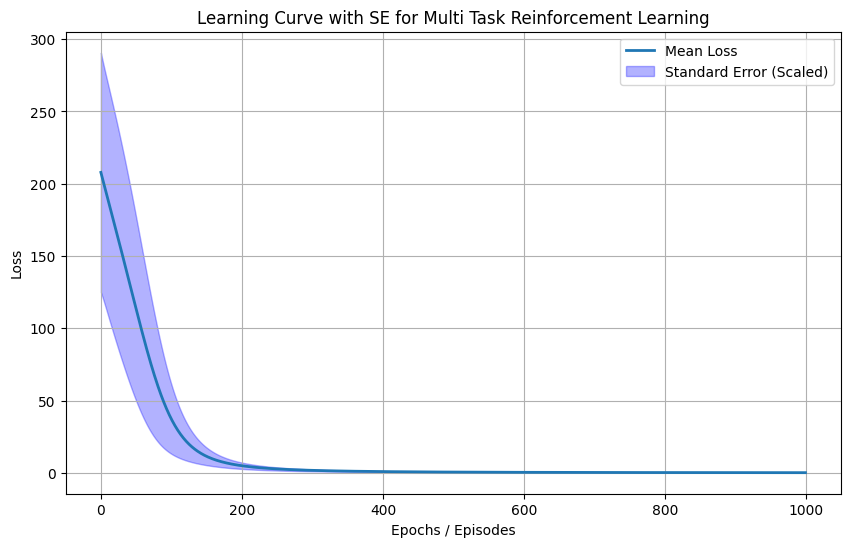

In [ ]:
plot_standard_error(mean_losses, std_err_losses, 'Learning Curve with SE for Multi Task Reinforcement Learning')